In [2]:
import pandas as pd
import re

# Load dataset
df = pd.read_excel('filtered_ds.xlsx')

# Cleaning function using only regex
def clean_text(text):
    text = str(text).lower()                             # Lowercase
    text = re.sub(r'\{\{.*?\}\}', '', text)              # Remove placeholders like {{Order Number}}
    text = re.sub(r'[^a-z0-9\s]', '', text)              # Remove special characters
    tokens = re.findall(r'\b\w+\b', text)                # Tokenization using regex
    return ' '.join(tokens)                              # Rejoin tokens as a string

# Apply to both columns
df['description'] = df['description'].apply(clean_text)
df['solution'] = df['solution'].apply(clean_text)

# Save cleaned dataset
df.to_excel('cleaned_filtered_ds.xlsx', index=False)

print("Cleaned dataset saved as 'cleaned_filtered_ds.xlsx'")

Cleaned dataset saved as 'cleaned_filtered_ds.xlsx'


Batches:   0%|          | 0/840 [00:00<?, ?it/s]

Batches:   0%|          | 0/840 [00:00<?, ?it/s]

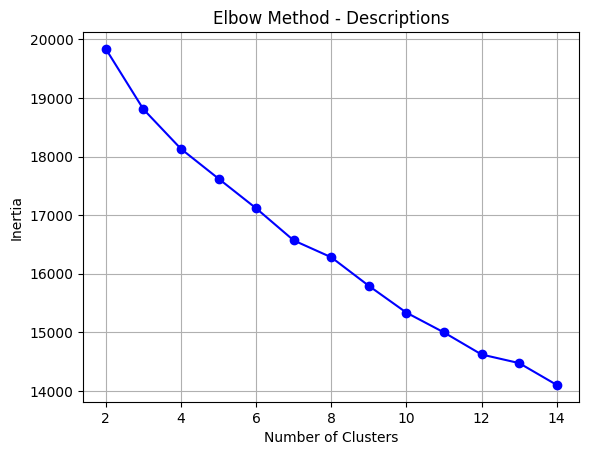

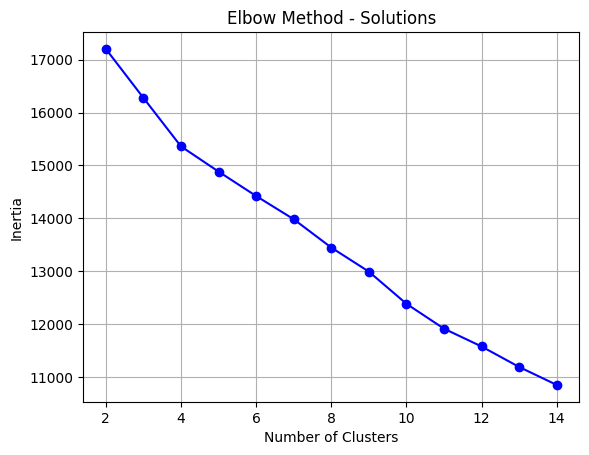

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load dataset
df = pd.read_excel("cleaned_filtered_ds.xlsx")
df.columns = df.columns.str.lower()

descriptions = df['description'].astype(str).tolist()
solutions = df['solution'].astype(str).tolist()
categories = df['category'].astype(str).tolist()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
desc_embeddings = normalize(model.encode(descriptions, show_progress_bar=True))
soln_embeddings = normalize(model.encode(solutions, show_progress_bar=True))

# Elbow Method for K

def plot_elbow_curve(embeddings, label):
    distortions = []
    K = range(2, 15)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method - {label}')
    plt.grid()
    plt.show()

# Plot elbow curves for both description and solution
plot_elbow_curve(desc_embeddings, "Descriptions")
plot_elbow_curve(soln_embeddings, "Solutions")


In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
k = 7  

desc_labels = KMeans(n_clusters=k, random_state=42).fit_predict(desc_embeddings)
soln_labels = KMeans(n_clusters=k, random_state=42).fit_predict(soln_embeddings)

def print_cluster_similarity(embeddings, labels, label_type):
    print(f"\n Intra-Cluster Cosine Similarity for {label_type.capitalize()} Embeddings")
    for cluster_id in range(k):
        indices = np.where(labels == cluster_id)[0]
        if len(indices) < 2:
            print(f"Cluster {cluster_id}: Not enough items to compute similarity")
            continue
        sims = cosine_similarity(embeddings[indices])
        upper_tri = np.triu_indices_from(sims, k=1)
        avg_sim = sims[upper_tri].mean()
        print(f"Cluster {cluster_id}: Avg Similarity = {avg_sim:.4f}")

print_cluster_similarity(desc_embeddings, desc_labels, "description")
print_cluster_similarity(soln_embeddings, soln_labels, "solution")

def extract_top_keywords(texts, labels, top_n=10):
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = np.array(tfidf.get_feature_names_out())

    print("\n Top Keywords per Cluster:")
    for cluster_id in range(k):
        indices = np.where(labels == cluster_id)[0]
        if len(indices) == 0:
            continue
        cluster_tfidf = tfidf_matrix[indices].mean(axis=0)
        top_indices = np.argsort(cluster_tfidf.A1)[::-1][:top_n]
        keywords = feature_names[top_indices]
        print(f"Cluster {cluster_id}: {', '.join(keywords)}")

# Top keywords from descriptions and solutions
extract_top_keywords(descriptions, desc_labels)
extract_top_keywords(solutions, soln_labels)


def print_cluster_category_distribution(labels, categories, label_type):
    print(f"\nCategory Distribution in {label_type.capitalize()} Clusters:")
    df_labels = pd.DataFrame({'cluster': labels, 'category': categories})
    for cluster_id in range(k):
        print(f"\nCluster {cluster_id}:")
        print(df_labels[df_labels['cluster'] == cluster_id]['category'].value_counts())

print_cluster_category_distribution(desc_labels, categories, "description")
print_cluster_category_distribution(soln_labels, categories, "solution")



 Intra-Cluster Cosine Similarity for Description Embeddings
Cluster 0: Avg Similarity = 0.3793
Cluster 1: Avg Similarity = 0.3771
Cluster 2: Avg Similarity = 0.2492
Cluster 3: Avg Similarity = 0.4102
Cluster 4: Avg Similarity = 0.6364
Cluster 5: Avg Similarity = 0.4558
Cluster 6: Avg Similarity = 0.3915

 Intra-Cluster Cosine Similarity for Solution Embeddings
Cluster 0: Avg Similarity = 0.4690
Cluster 1: Avg Similarity = 0.5172
Cluster 2: Avg Similarity = 0.4503
Cluster 3: Avg Similarity = 0.4722
Cluster 4: Avg Similarity = 0.5232
Cluster 5: Avg Similarity = 0.7491
Cluster 6: Avg Similarity = 0.4176

 Top Keywords per Cluster:
Cluster 0: account, to, the, my, on, profile, do, user, standard, change
Cluster 1: to, of, money, can, see, the, refund, help, check, in
Cluster 2: to, order, help, do, an, some, customer, your, purchase, can
Cluster 3: address, to, shipping, delivery, newsletter, signup, up, the, my, with
Cluster 4: cancel, purchase, canceling, cancelling, order, to, cancella

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have:
# - desc_embeddings: np.array of description embeddings
# - soln_embeddings: np.array of solution embeddings
# - desc_labels: cluster labels for description
# - soln_labels: cluster labels for solution
# - k: number of clusters (e.g., 7)

# Initialize similarity matrix
similarity_matrix = np.zeros((k, k))

# Compute similarity between description cluster i and solution cluster j
for i in range(k):
    desc_indices = np.where(desc_labels == i)[0]
    desc_subset = desc_embeddings[desc_indices]

    for j in range(k):
        soln_indices = np.where(soln_labels == j)[0]
        soln_subset = soln_embeddings[soln_indices]

        if len(desc_subset) == 0 or len(soln_subset) == 0:
            similarity = np.nan
        else:
            sim_scores = cosine_similarity(desc_subset, soln_subset)
            similarity = sim_scores.mean()

        similarity_matrix[i][j] = similarity

# Create a DataFrame for easier viewing
cluster_similarity_df = pd.DataFrame(
    similarity_matrix,
    index=[f'Desc_{i}' for i in range(k)],
    columns=[f'Sol_{j}' for j in range(k)]
)

# Save to Excel
cluster_similarity_df.to_excel("cluster_similarity_matrix.xlsx")

print("✅ Similarity matrix generated and saved as 'cluster_similarity_matrix.xlsx'")
display(cluster_similarity_df)


✅ Similarity matrix generated and saved as 'cluster_similarity_matrix.xlsx'


,Sol_0,Sol_1,Sol_2,Sol_3,Sol_4,Sol_5,Sol_6
Desc_0,0.346393,0.052225,0.154229,0.150500,0.199228,0.151364,0.144620
Desc_1,0.110463,0.112446,0.155272,0.297468,0.278672,0.188073,0.164932
Desc_2,0.128148,0.156543,0.230380,0.189520,0.189410,0.153171,0.228728
Desc_3,0.207090,0.273849,0.280699,0.192726,0.199424,0.128975,0.246798
Desc_4,0.213812,0.159016,0.254359,0.274391,0.494651,0.227192,0.211788
Desc_5,0.146153,0.175298,0.237432,0.376316,0.264876,0.348667,0.203390
Desc_6,0.070444,0.343337,0.251206,0.209841,0.183020,0.172065,0.173307


In [8]:
with open("desc_embeddings.pkl", "wb") as f:
    pickle.dump(desc_embeddings, f)

with open("soln_embeddings.pkl", "wb") as f:
    pickle.dump(soln_embeddings, f)

print("Embeddings saved to disk as .pkl files")

Embeddings saved to disk as .pkl files
